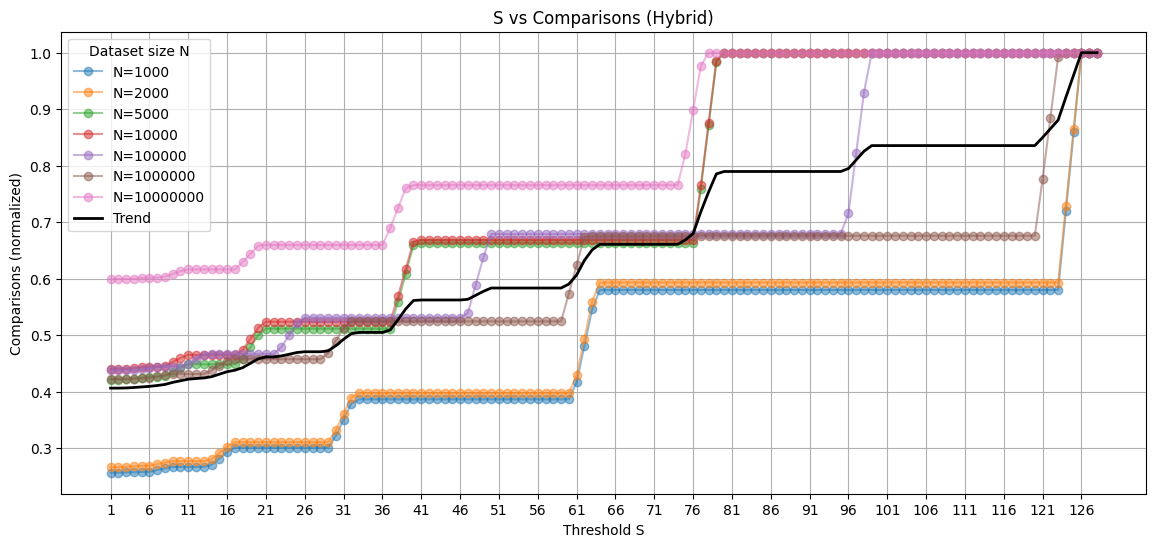

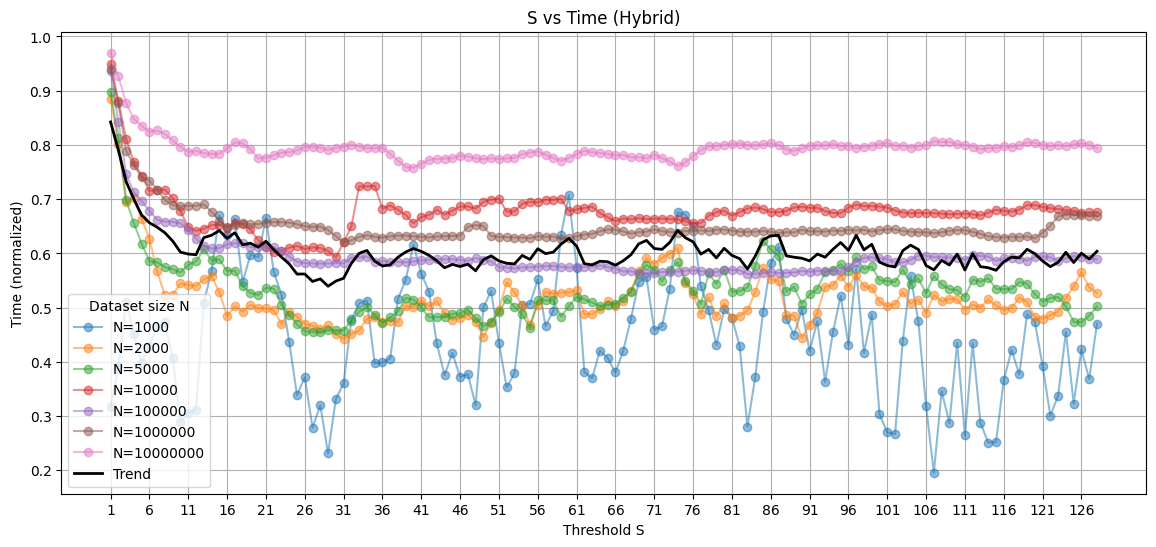

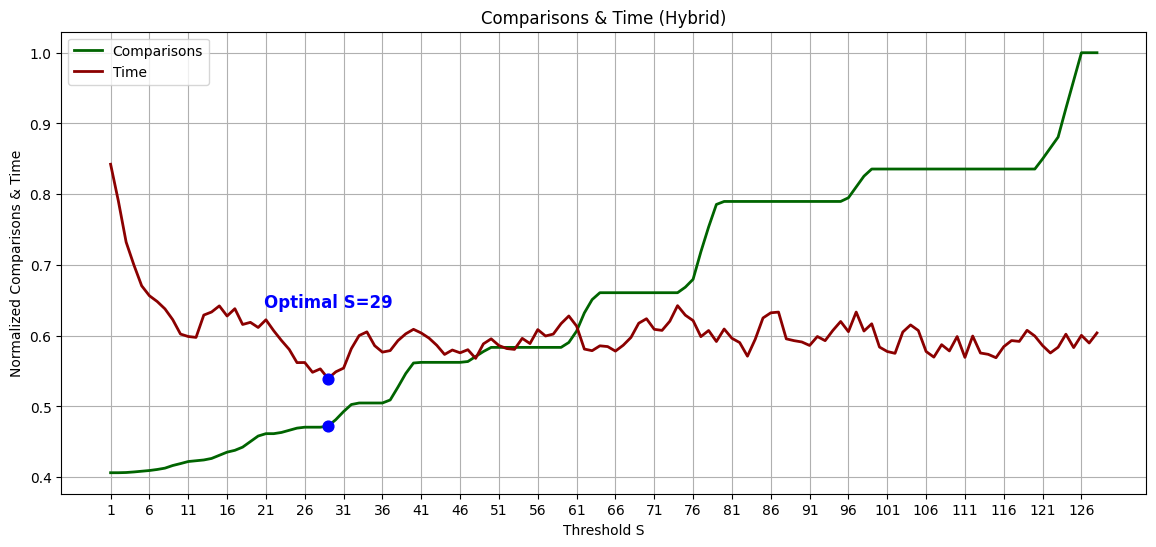

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Load CSV
df = pd.read_csv("hybrid_sort_results.csv")  # Columns: N, S, Comparisons, Time

Ns = sorted(df['N'].unique())
Ss = sorted(df['S'].unique())

# --- Normalize and smooth ---
def normalize_and_smooth(values, window=3):
    scaled = values / np.max(values)
    smooth = uniform_filter1d(scaled, size=window)
    return smooth

# Prepare trend storage
comp_trends = []
time_trends = []

# --- Plot 1: S vs Comparisons ---
plt.figure(figsize=(14,6))
for N in Ns:
    subset = df[df['N'] == N].sort_values('S')
    smooth_comp = normalize_and_smooth(subset['Comparisons'].values)
    comp_trends.append(smooth_comp)
    plt.plot(Ss, smooth_comp, alpha=0.5, label=f'N={N}', marker='o')

comp_trends = np.array(comp_trends)
comp_trend = np.mean(comp_trends, axis=0)
plt.plot(Ss, comp_trend, color='black', linewidth=2, label='Trend')

plt.xlabel('Threshold S')
plt.ylabel('Comparisons (normalized)')
plt.title('S vs Comparisons (Hybrid)')
plt.xticks(Ss[::5])
plt.legend(title='Dataset size N')
plt.grid(True)
plt.show()

# --- Plot 2: S vs Time ---
plt.figure(figsize=(14,6))
for N in Ns:
    subset = df[df['N'] == N].sort_values('S')
    smooth_time = normalize_and_smooth(subset['Time'].values)
    time_trends.append(smooth_time)
    plt.plot(Ss, smooth_time, alpha=0.5, label=f'N={N}', marker='o')

time_trends = np.array(time_trends)
time_trend = np.mean(time_trends, axis=0)
plt.plot(Ss, time_trend, color='black', linewidth=2, label='Trend')

plt.xlabel('Threshold S')
plt.ylabel('Time (normalized)')
plt.title('S vs Time (Hybrid)')
plt.xticks(Ss[::5])
plt.legend(title='Dataset size N')
plt.grid(True)
plt.show()


# --- Plot 3: Overlay with optimal point ---
plt.figure(figsize=(14,6))

# Plot trends
plt.plot(Ss, comp_trend, color='darkgreen', linewidth=2, label='Comparisons')
plt.plot(Ss, time_trend, color='darkred', linewidth=2, label='Time')

# Find optimal S where both are minimized together
combined = comp_trend + time_trend
opt_idx = np.argmin(combined)
S_opt = Ss[opt_idx]
y_comp = comp_trend[opt_idx]
y_time = time_trend[opt_idx]

# Mark the optimal point on both lines
plt.scatter(S_opt, y_comp, color='blue', s=60, zorder=5)
plt.scatter(S_opt, y_time, color='blue', s=60, zorder=5)

# Add label slightly above the higher curve
y_label = max(y_comp, y_time)
plt.text(S_opt, y_label + 0.10, f'Optimal S={S_opt}', ha='center', color='blue', fontsize=12, fontweight='bold')

# Axis labels, title, ticks
plt.xlabel('Threshold S')
plt.ylabel('Normalized Comparisons & Time')
plt.title('Comparisons & Time (Hybrid)')
plt.xticks(Ss[::5])  # every 5th S
plt.grid(True)
plt.legend()
plt.show()


